# Отток клиентов

 - *Перед нами данные о пользователях "Бета-Банка". Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. интересно так ли это? Узнаем, применив методы машинного обучения к предоставленным данным и спрогнозируем уйдет ли клиент из банка в ближайшее время или нет?*

 - Наши модели должны будут достигать высоких показателей, а именно F1 score более 0.59 и соответствующие высокие показатели AUC-Roc, также для наглядности сопроводим их графиком.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler, Normalizer

In [2]:
data = pd.read_csv(r"C:\Users\yana\Desktop\проекты\отток клиентов из банка\Churn.csv")

In [3]:
def prepare(df): #фунция предобработки данных
    display(df.head())
    display(df.info())
    display(df.isna().sum())
    display(df.duplicated().sum())

In [4]:
prepare(data)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

0

In [5]:
data['Balance'] = np.ceil(data['Balance'])
data['Balance'] = data['Balance'].astype('int') 
#округлим и переведем в целочисленное тип значения баланса

In [6]:
data['EstimatedSalary'] = np.ceil(data['EstimatedSalary'])
data['EstimatedSalary'] = data['EstimatedSalary'].astype('int') 
#округлим и переведем в целочисленное тип значения  предполагаемого дохода

In [7]:
data = data.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1) 
#фамилия, id и номер в таблице не так важны в дальнейших расчетах

In [8]:
data['Tenure'] = data['Tenure'].fillna(-1) #заполнила пропуски -1

In [9]:
data['Tenure'] = data['Tenure'].astype('object') 
#изменила тип данных чтобы потом омжно было выполнить технику OHE

In [10]:
data = pd.get_dummies(data, drop_first=True) 
#изменяем качественные данные на категориальные с помощью дамми-ловушек непрямым кодированием

C:\Users\yana\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


## Исследование задачи

In [11]:
data['Exited'].value_counts() #значений класса "0" почти в 4 раза больше

0    7963
1    2037
Name: Exited, dtype: int64

In [12]:
x = data.drop(['Exited'], axis=1)
y = data['Exited']
x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.25, random_state=12345)

In [13]:
%%time
best_result = 0
best_depth = 0
for depth in range (1, 30):
    model =  DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(x_train, y_train) # обучаем модель на тренировочной выборке
    predictions_valid = model.predict(x_valid) # вычисляем предсказания модели на валидационной выборке
    result = accuracy_score(y_valid, predictions_valid) # определяем качество модели на валидационной выборке
    if result > best_result:
        best_result = result
        best_depth = depth
print("наилучшая глубина", best_depth, "наилучшая точность при этом", best_result)

наилучшая глубина 6 наилучшая точность при этом 0.854
CPU times: total: 906 ms
Wall time: 1.38 s


In [14]:
model = DecisionTreeClassifier(random_state=12345, max_depth = best_depth)
model.fit(x_train, y_train) #подставляем наилучшее значение гиперпараметра в модель
predictions_valid = model.predict(x_valid)
accuracy = accuracy_score(y_valid, predictions_valid)
print("Accuracy наилучшей модели на тестовой выборке:", accuracy)

Accuracy наилучшей модели на тестовой выборке: 0.854


In [15]:
%%time
best_result_1 = 0
best_depth_1 = 0
best_estimators_1 = 0
for depth in range(5, 13):
    for est in range (30, 60):
        model_1 = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_1.fit(x_train, y_train)
        predictions_valid_1 = model_1.predict(x_valid) 
        result = accuracy_score(y_valid, predictions_valid_1)
        if result > best_result_1:
            best_result_1 = result
            best_estimators_1 = est
            best_depth_1 = depth

print("Accuracy наилучшей модели на валидационной выборке:", best_result_1, "Лучшее количество деревьев", 
      best_estimators_1, 'Лучшая глубина дерева:', best_depth_1)

Accuracy наилучшей модели на валидационной выборке: 0.8568 Лучшее количество деревьев 50 Лучшая глубина дерева: 12
CPU times: total: 52.4 s
Wall time: 55.5 s


In [16]:
model_1 = RandomForestClassifier(random_state=12345, n_estimators = best_estimators_1, max_depth=best_depth_1)
model_1.fit(x_train, y_train) 
predictions_valid_1 = model_1.predict(x_valid)
accuracy_1 = accuracy_score(y_valid, predictions_valid_1)
print("Accuracy наилучшей модели на тестовой выборке:", accuracy_1)

Accuracy наилучшей модели на тестовой выборке: 0.8568


In [17]:
model_2 = LogisticRegression(random_state = 12345, solver= 'liblinear')
model_2.fit(x_train, y_train) 
predictions_valid_2 = model_2.predict(x_valid)
accuracy_2 = accuracy_score(y_valid, predictions_valid_2)
print("Accuracy наилучшей модели на тестовой выборке:", accuracy_2)

Accuracy наилучшей модели на тестовой выборке: 0.7824


In [18]:
print(classification_report(y_valid, predictions_valid, zero_division='warn')) #для решающего леса

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1965
           1       0.81      0.41      0.55       535

    accuracy                           0.85      2500
   macro avg       0.84      0.69      0.73      2500
weighted avg       0.85      0.85      0.83      2500



In [19]:
print(classification_report(y_valid, predictions_valid_1, zero_division='warn')) #для случайного леса

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      1965
           1       0.83      0.42      0.56       535

    accuracy                           0.86      2500
   macro avg       0.84      0.70      0.74      2500
weighted avg       0.85      0.86      0.84      2500



In [20]:
print(classification_report(y_valid, predictions_valid_2, zero_division='warn')) #для логистической регресии

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      1965
           1       0.44      0.06      0.11       535

    accuracy                           0.78      2500
   macro avg       0.62      0.52      0.49      2500
weighted avg       0.72      0.78      0.71      2500



**Вывод:** accuracy может быть и большой, но вот более подробные метрики показывают, что несбалансированные данные не такие уж и точне предсказатели, как минимум из-за того что данных классов "0" в 4 раза больще и поэтому даже простые модели будут правы в 4 раза больше, чем это есть на самом деле.

## Борьба с дисбалансом

In [21]:
x = data.drop('Exited', axis=1)
y = data['Exited']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.4, random_state=12345, stratify=y)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.5, random_state=12345, stratify=y_valid)

In [22]:
numeric = ['Balance', 'EstimatedSalary','Age', 'CreditScore', 'NumOfProducts']
scaler = StandardScaler()
scaler.fit(x_train[numeric])
x_train[numeric]=scaler.transform(x_train[numeric])
x_valid[numeric] = scaler.transform(x_valid[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])
pd.options.mode.chained_assignment = None

In [23]:
norm = Normalizer()
norm.fit(x_train[numeric])
x_train[numeric]=norm.transform(x_train[numeric])
x_valid[numeric] = norm.transform(x_valid[numeric])
x_test[numeric] = norm.transform(x_test[numeric])
pd.options.mode.chained_assignment = None #нормализировали данные как один из этапов балансировки данных.

In [24]:
def upsample(x, y, repeat):
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    x_upsampled = pd.concat([x_zeros] + [x_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    x_upsampled, y_upsampled = shuffle(
        x_upsampled, y_upsampled, random_state=12345)
    
    return x_upsampled, y_upsampled

x_upsampled, y_upsampled = upsample(x_train, y_train, 4) #увеличили положительный класс для баланса

In [25]:
def downsample(x, y, fraction):
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    x_downsampled = pd.concat(
        [x_zeros.sample(frac=fraction, random_state=12345)] + [x_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=12345)] + [y_ones])
    
    x_downsampled, y_downsampled = shuffle(
        x_downsampled, y_downsampled, random_state=12345)
    
    return x_downsampled, y_downsampled

x_downsampled, y_downsampled = downsample(x_train, y_train, 0.25) 
#уменьшили отрицательный класс для баланса, будем выбирать какие параметры покаывают лучше результат.

In [26]:
%%time
best_result_DTree_b = 0
best_depth_DTree_b= 0
for depth in range (1, 30):
    model_DTree_b =  DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight = 'balanced')
    model_DTree_b.fit(x_train, y_train) # обучаем модель на тренировочной выборке
    predictions_valid_DTree_b = model_DTree_b.predict(x_valid) # вычисляем предсказания модели на валидационной выборке
    result_DTree_b = f1_score(y_valid, predictions_valid_DTree_b) # определяем качество модели на валидационной выборке
    if result_DTree_b > best_result_DTree_b:
        best_result_DTree_b = result_DTree_b
        best_depth_DTree_b = depth
print("наилучшая глубина", best_depth_DTree_b, "наилучшая точность при этом", best_result_DTree_b)

наилучшая глубина 6 наилучшая точность при этом 0.5650140318054256
CPU times: total: 1.11 s
Wall time: 1.14 s


In [27]:
model_DTree_b = DecisionTreeClassifier(random_state=12345, max_depth = best_depth, class_weight = 'balanced')
model_DTree_b.fit(x_train, y_train) #подставляем наилучшее значение гиперпараметра в модель
predictions_valid_DTree_b = model_DTree_b.predict(x_valid)
f1_DTree_b = f1_score(y_valid, predictions_valid_DTree_b)
print("F1 наилучшей модели на тестовой выборке:", f1_DTree_b)

F1 наилучшей модели на тестовой выборке: 0.5650140318054256


In [28]:
%%time
best_result_DTree_up = 0
best_depth_DTree_up= 0
for depth in range (1, 30):
    model_DTree_up =  DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_DTree_up.fit(x_upsampled, y_upsampled) # обучаем модель на тренировочной выборке
    predictions_valid_DTree_up = model_DTree_up.predict(x_valid) # вычисляем предсказания модели на валидационной выборке
    result_DTree_up = f1_score(y_valid, predictions_valid_DTree_up) # определяем качество модели на валидационной выборке
    if result_DTree_up > best_result_DTree_up:
        best_result_DTree_up = result_DTree_up
        best_depth_DTree_up = depth
print("наилучшая глубина", best_depth_DTree_up, "наилучшая точность при этом", best_result_DTree_up)

наилучшая глубина 6 наилучшая точность при этом 0.5722222222222222
CPU times: total: 1.3 s
Wall time: 1.47 s


In [29]:
model_DTree_up = DecisionTreeClassifier(random_state=12345, max_depth = best_depth_DTree_up)
model_DTree_up.fit(x_train, y_train) #подставляем наилучшее значение гиперпараметра в модель
predictions_valid_DTree_up = model_DTree_up.predict(x_valid)
f1_DTree_up = f1_score(y_valid, predictions_valid_DTree_up)
print("F1 наилучшей модели на тестовой выборке:", f1_DTree_up)

F1 наилучшей модели на тестовой выборке: 0.5506807866868381


In [30]:
%%time
best_result_DTree_dw = 0
best_depth_DTree_dw= 0
for depth in range (1, 20):
    model_DTree_dw =  DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_DTree_dw.fit(x_downsampled, y_downsampled) # обучаем модель на тренировочной выборке
    predictions_valid_DTree_dw = model_DTree_dw.predict(x_valid) # вычисляем предсказания модели на валидационной выборке
    result_DTree_dw = f1_score(y_valid, predictions_valid_DTree_dw) # определяем качество модели на валидационной выборке
    if result_DTree_dw > best_result_DTree_dw:
        best_result_DTree_dw = result_DTree_dw
        best_depth_DTree_dw = depth
print("наилучшая глубина", best_depth_DTree_dw, "наилучшая точность при этом", best_result_DTree_dw)

наилучшая глубина 8 наилучшая точность при этом 0.5757864632983795
CPU times: total: 156 ms
Wall time: 297 ms


In [31]:
model_DTree_dw = DecisionTreeClassifier(random_state=12345, max_depth = best_depth_DTree_dw)
model_DTree_dw.fit(x_train, y_train) #подставляем наилучшее значение гиперпараметра в модель
predictions_valid_DTree_dw = model_DTree_b.predict(x_valid)
f1_DTree_dw = f1_score(y_valid, predictions_valid_DTree_dw)
print("F1 наилучшей модели на тестовой выборке:", f1_DTree_dw)

F1 наилучшей модели на тестовой выборке: 0.5650140318054256


In [32]:
%%time
best_result_RTree_b = 0
best_depth_RTree_b = 0
best_estimators_RTree_b = 0
for depth in range(5, 13):
    for est in range (20, 50):
        model_RTree_b = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight = 'balanced')
        model_RTree_b.fit(x_train, y_train)
        predictions_valid_RTree_b = model_RTree_b.predict(x_valid) 
        result_RTree_b = f1_score(y_valid, predictions_valid_RTree_b)
        if result_RTree_b > best_result_RTree_b:
            best_result_RTree_b = result_RTree_b
            best_estimators_RTree_b = est
            best_depth_RTree_b = depth

print("F1 наилучшей модели на валидационной выборке:", best_result_RTree_b, "Лучшее количество деревьев", 
      best_estimators_RTree_b, 'Лучшая глубина дерева:', best_depth_RTree_b)

F1 наилучшей модели на валидационной выборке: 0.6415981198589894 Лучшее количество деревьев 38 Лучшая глубина дерева: 10
CPU times: total: 40 s
Wall time: 46 s


In [33]:
model_RTree_b = RandomForestClassifier(random_state=12345, n_estimators = best_estimators_RTree_b, 
                                       max_depth=best_depth_RTree_b, class_weight = 'balanced')
model_RTree_b.fit(x_train, y_train) 
predictions_valid_RTree_b = model_RTree_b.predict(x_valid)
f1_RTree_b = f1_score(y_valid, predictions_valid_RTree_b)
print("F1 наилучшей модели на тестовой выборке:", f1_RTree_b)

F1 наилучшей модели на тестовой выборке: 0.6415981198589894


In [34]:
%%time
best_result_RTree_up = 0
best_depth_RTree_up = 0
best_estimators_RTree_up = 0
for depth in range(5, 13):
    for est in range (30, 60):
        model_RTree_up = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_RTree_up.fit(x_upsampled, y_upsampled)
        predictions_valid_RTree_up = model_RTree_up.predict(x_valid) 
        result_RTree_up = f1_score(y_valid, predictions_valid_RTree_up)
        if result_RTree_up > best_result_RTree_up:
            best_result_RTree_up = result_RTree_up
            best_estimators_RTree_up = est
            best_depth_RTree_up = depth

print("F1 наилучшей модели на валидационной выборке:", best_result_RTree_up, "Лучшее количество деревьев", 
      best_estimators_RTree_up, 'Лучшая глубина дерева:', best_depth_RTree_up)

F1 наилучшей модели на валидационной выборке: 0.6411378555798687 Лучшее количество деревьев 47 Лучшая глубина дерева: 10
CPU times: total: 54 s
Wall time: 1min 30s


In [35]:
model_RTree_up = RandomForestClassifier(random_state=12345, n_estimators = best_estimators_RTree_up, 
                                        max_depth=best_depth_RTree_up)
model_RTree_up.fit(x_train, y_train) 
predictions_valid_RTree_up = model_RTree_up.predict(x_valid)
f1_RTree_up = f1_score(y_valid, predictions_valid_RTree_up)
print("F1 наилучшей модели на тестовой выборке:", f1_RTree_up) #accuracy_RTree_up)

F1 наилучшей модели на тестовой выборке: 0.5296950240770466


In [36]:
%%time
best_result_RTree_dw = 0
best_depth_RTree_dw = 0
best_estimators_RTree_dw = 0
for depth in range(5, 13):
    for est in range (20, 70):
        model_RTree_dw = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_RTree_dw.fit(x_downsampled, y_downsampled)
        predictions_valid_RTree_dw = model_RTree_dw.predict(x_valid) 
        result_RTree_dw = f1_score(y_valid, predictions_valid_RTree_dw)
        if result_RTree_dw > best_result_RTree_dw:
            best_result_RTree_dw = result_RTree_dw
            best_estimators_RTree_dw = est
            best_depth_RTree_dw = depth

print("F1 наилучшей модели на валидационной выборке:", best_result_RTree_dw, "Лучшее количество деревьев", 
      best_estimators_RTree_dw, 'Лучшая глубина дерева:', best_depth_RTree_dw)

F1 наилучшей модели на валидационной выборке: 0.6107445805843543 Лучшее количество деревьев 49 Лучшая глубина дерева: 9
CPU times: total: 38.9 s
Wall time: 57.7 s


In [37]:
model_RTree_dw = RandomForestClassifier(random_state=12345, n_estimators = best_estimators_RTree_dw, 
                                        max_depth=best_depth_RTree_dw)
model_RTree_dw.fit(x_train, y_train) 
predictions_valid_RTree_dw = model_RTree_dw.predict(x_valid)
f1_RTree_dw = f1_score(y_valid, predictions_valid_RTree_dw)
print("F1 наилучшей модели на тестовой выборке:", f1_RTree_dw) #accuracy_RTree_dw

F1 наилучшей модели на тестовой выборке: 0.529968454258675


## Тестирование модели

In [38]:
def Score (models, x_test, y_test, x_valid, y_valid):
    for model in models:
        predictions_test = model.predict(x_test)
        f1 = f1_score(y_test, predictions_test)
        probabilities_valid = model.predict_proba(x_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
        print('Модель:', model)
        print('F1-величина:', f1)
        print('AUC-ROC величина', auc_roc)
        print()

models = [model_DTree_b, model_DTree_up, model_DTree_dw, model_RTree_b, model_RTree_up, model_RTree_dw]

In [39]:
Score(models, x_test, y_test, x_valid, y_valid)

Модель: DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=12345)
F1-величина: 0.5637707948243992
AUC-ROC величина 0.8311779485663612

Модель: DecisionTreeClassifier(max_depth=6, random_state=12345)
F1-величина: 0.5070866141732282
AUC-ROC величина 0.8256624729037344

Модель: DecisionTreeClassifier(max_depth=8, random_state=12345)
F1-величина: 0.48011782032400585
AUC-ROC величина 0.8137154830525175

Модель: RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=38,
                       random_state=12345)
F1-величина: 0.5914489311163896
AUC-ROC величина 0.8597983791506553

Модель: RandomForestClassifier(max_depth=10, n_estimators=47, random_state=12345)
F1-величина: 0.47412353923205347
AUC-ROC величина 0.8618152034683221

Модель: RandomForestClassifier(max_depth=9, n_estimators=49, random_state=12345)
F1-величина: 0.4776119402985075
AUC-ROC величина 0.8598430264065424



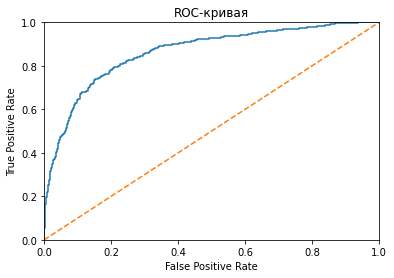

In [40]:
m_roc= RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=35,
                       random_state=12345)
m_roc.fit(x_train, y_train)

probabilities_valid = m_roc.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid) 
plt.figure()
plt.plot(fpr, tpr) # график 

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC-кривая")

plt.show()

**Вывод:** с задачей справился лучше всего модель случайного леса с методом балансировки данных "class_weight = balanced"